# Project 2: Clustering
**ECE 219**: Large-Scale Data Mining: Models and Algorithms [Winter 2021]

Prof. Vwani Roychowdhury

UCLA, Department of ECE

### Q9 - 15

In [45]:
from sklearn.datasets import fetch_20newsgroups
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import string
import urllib
import zipfile
import sys
from scipy.optimize import linear_sum_assignment
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=4, suppress=True)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Question 9
Load documents with the same configuration as in Question 1, but for ALL
20 categories. Construct the TF-IDF matrix, reduce its dimensionality properly using either
NMF or SVD, and perform K-Means clustering with n_components=20 . Visualize the
contingency matrix and report the five clustering metrics.

Configuration required:

Loaded documents of all 20 categories from 20Newsgroups.

min_df = 3, exculded stopwords, removed headers and footers.

SVD to reduce dimensions of TF-IDF matrix with n_components = 1000

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
news_data = fetch_20newsgroups(
    subset='all',
    shuffle=True, 
    random_state=RANDOM_SEED,
    remove=('header', 'footer')
)

inputs = news_data.data
labels = news_data.target

target_names = news_data.target_names

In [86]:
print(target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [87]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, stop_words='english')

inputs_tfidf = tfidf_vectorizer.fit_transform(inputs)
print("inputs_tfidf.shape:", inputs_tfidf.shape)

inputs_tfidf.shape: (18846, 52295)


In [40]:
from sklearn.decomposition import TruncatedSVD

Visualized the variance explained by upto 1000 components. They seem to explain almost 50% of the variance in input data, and each further component explains a very small fraction of the variance.

In [45]:
svd = TruncatedSVD(n_components=1000,random_state=RANDOM_SEED)
inputs_svd = svd.fit_transform(inputs_tfidf)

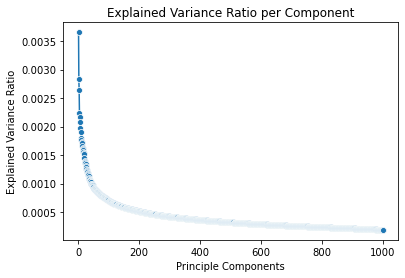

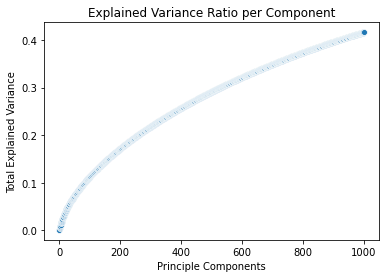

In [46]:
xs = np.arange(1,1001)
ys = sorted(svd.explained_variance_ratio_, reverse=True)
ys_cum = np.cumsum(svd.explained_variance_ratio_)

g = sns.lineplot(
    x=xs, 
    y=ys,
    marker='o'
)
g.set_xlabel('Principle Components')
g.set_ylabel('Explained Variance Ratio')
g.set_title('Explained Variance Ratio per Component')
plt.show()

g = sns.lineplot(
    x=xs, 
    y=ys_cum,
    marker='o'
)
g.set_xlabel('Principle Components')
g.set_ylabel('Total Explained Variance')
g.set_title('Explained Variance Ratio per Component')
plt.show()

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (
    contingency_matrix, 
    homogeneity_score, 
    v_measure_score, 
    completeness_score, 
    adjusted_rand_score, 
    adjusted_mutual_info_score
)
from plotmat import plot_mat

#### A function to display table of required scores:

In [51]:
def get_cluster_metrics(y_true, y_pred, metrics=None):
    if not metrics:
        metrics = [
            homogeneity_score,
            completeness_score,
            v_measure_score,
            adjusted_rand_score,
            adjusted_mutual_info_score
        ]
    d = {}
    for m in metrics:
        d[m.__name__] = m(y_true, y_pred)
    df = pd.DataFrame(d, index=[0]).T
    df.reset_index(inplace=True)
    df.rename(columns={'index':'metric', 0:'score'}, inplace=True)
    return df

Using n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300, 500, 800] test the multi class classification:

In [39]:
km = KMeans(
    n_clusters= len(target_names), 
    random_state=0,
    max_iter=5000,
    n_init=50
)

In [54]:
scores = []
n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300, 500, 800]
for r in n_components:
    inputs_svd = TruncatedSVD(n_components=r, random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_svd)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.027941,0.031138,0.029453,0.005799,0.026110
2,0.211032,0.224915,0.217753,0.064692,0.215137
3,0.232702,0.242342,0.237424,0.079573,0.234909
5,0.313221,0.332460,0.322554,0.123212,0.320297
10,0.339986,0.379278,0.358559,0.139547,0.356361
20,0.287669,0.383175,0.328624,0.092857,0.326112
50,0.310314,0.413422,0.354523,0.093870,0.352104
100,0.275215,0.381518,0.319763,0.083114,0.317164
300,0.299456,0.402700,0.343488,0.098837,0.340994
500,0.284961,0.451065,0.349270,0.087328,0.346626


#### We see that n_components = 5 and 10 result in very good scores
Displaying the clustering scores and contingency matrix with n_components = 5

In [41]:
#n = 5
inputs_svd = TruncatedSVD(n_components=5, random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_svd)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.313221
1,completeness_score,0.332460
2,v_measure_score,0.322554
3,adjusted_rand_score,0.123212
4,adjusted_mutual_info_score,0.320297


Contingency table (SVD n_components = 5, Kmeans)


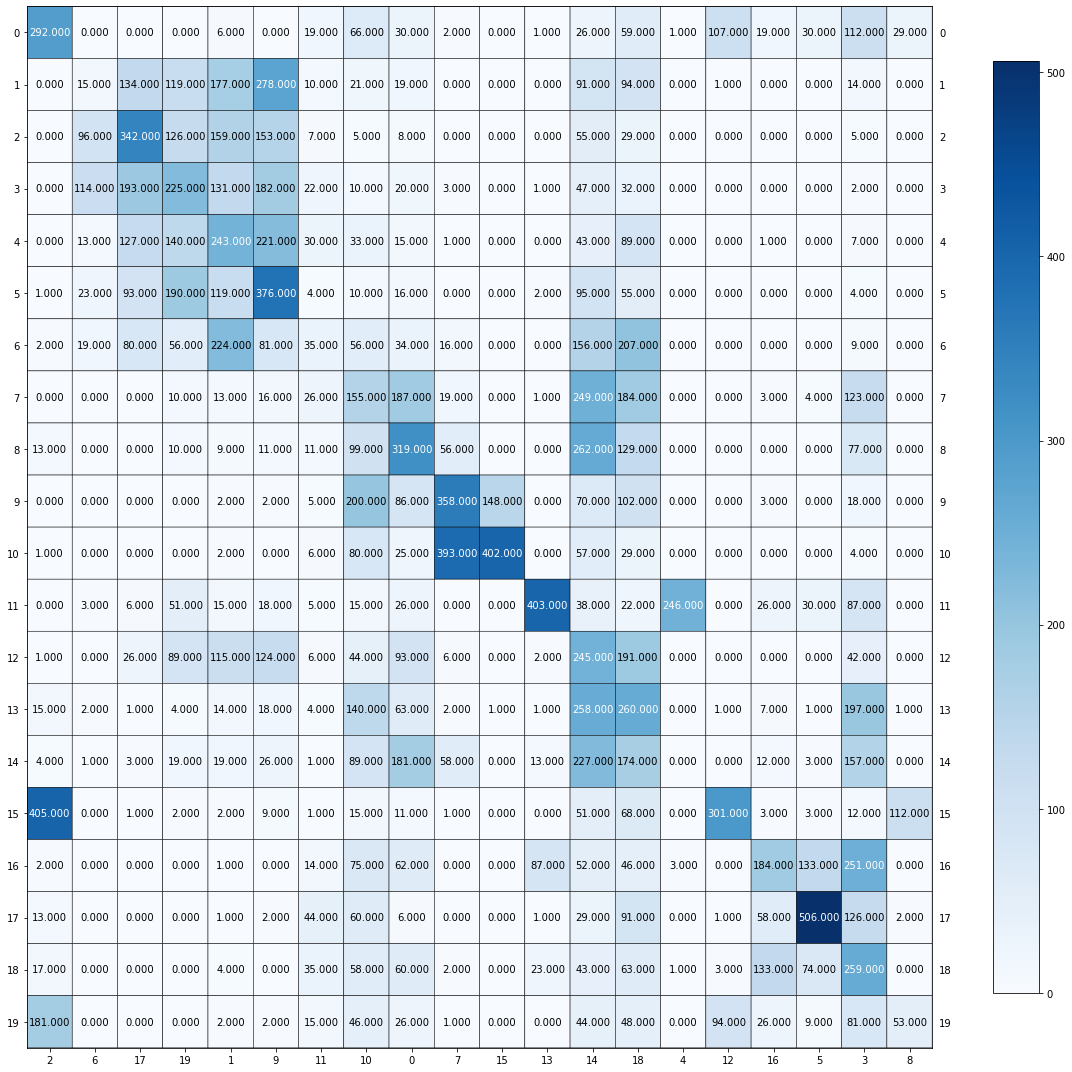

In [42]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
print("Contingency table (SVD n_components = 5, Kmeans)")
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

Displaying the metrics and the contingency matrix with n_components = 10

In [43]:
#n = 10
inputs_svd = TruncatedSVD(n_components=10, random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_svd)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.339986
1,completeness_score,0.379278
2,v_measure_score,0.358559
3,adjusted_rand_score,0.139547
4,adjusted_mutual_info_score,0.356361


Contingency table (SVD n_components = 10, Kmeans)


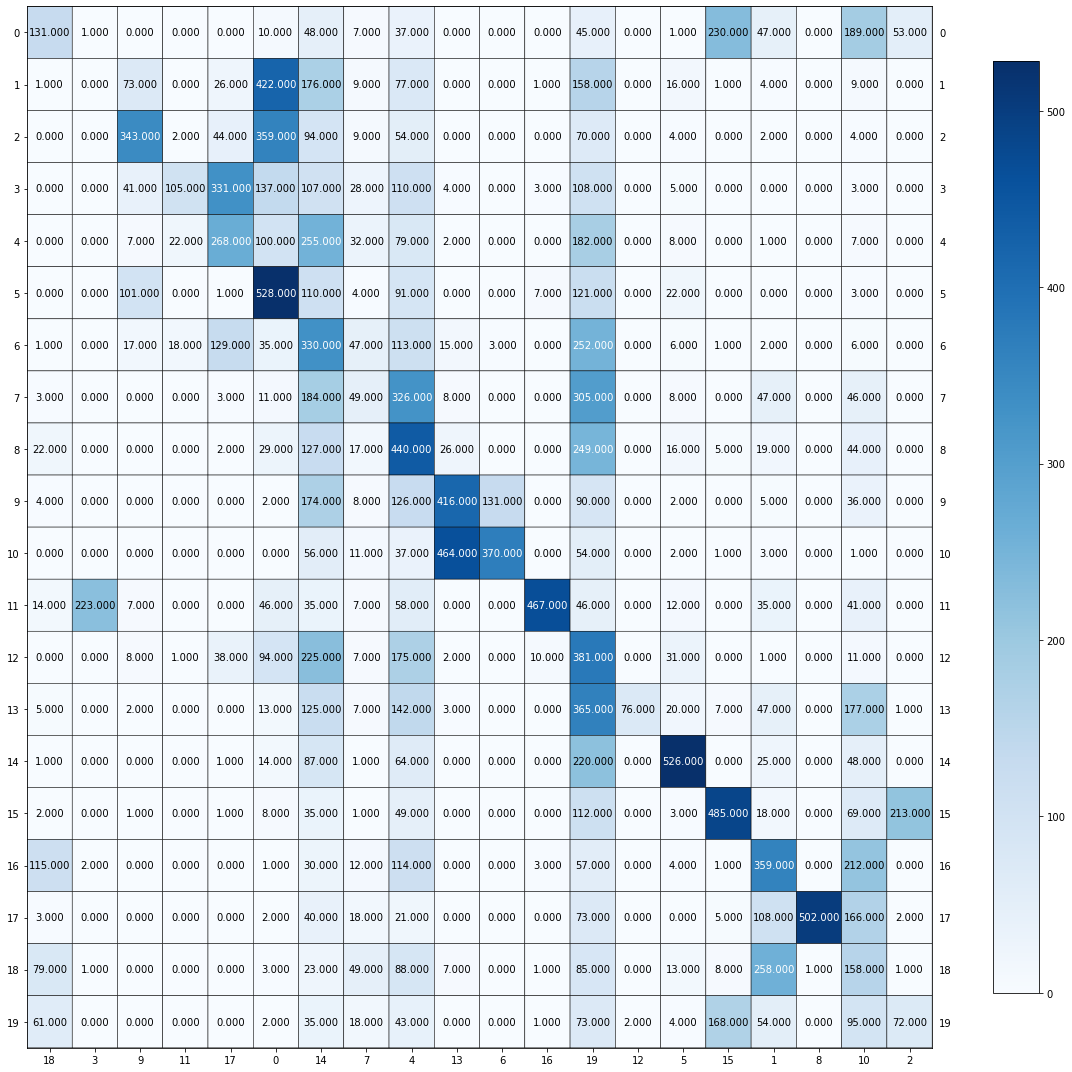

In [44]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
print("Contingency table (SVD n_components = 10, Kmeans)")
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## Question 10

By default sklearn.decomposition.NMF uses Frobenius norm as its cost function. Another
choice is Kullback-Leibler divergence. It is shown that with this cost function, NMF is equivalent to Probabilistic Latent Semantic Analysis (PLSA)[4]. Try Kullback-Leibler divergence
for NMF and see whether it helps with the clustering of our text data. Report the five
evaluation metrics.

Using NMF decomposition, with Kullback-Leibler divergence as the distance measure

In [62]:
from sklearn.decomposition import NMF

In [26]:
km = KMeans(
    n_clusters=len(target_names), 
    random_state=0,
    max_iter=5000,
    n_init=50
)

Checking which n_components gives better results when used NMF decompostion with KL divergence

In [64]:
scores = []
n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300]
for r in n_components:
    inputs_nmf = NMF(n_components=r, init='random', solver = 'mu', beta_loss = 'kullback-leibler', random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_nmf)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.030556,0.034513,0.032414,0.006957,0.029031
2,0.198715,0.225536,0.211277,0.063138,0.208523
3,0.256536,0.278224,0.266940,0.093704,0.264456
5,0.350546,0.374438,0.362098,0.155914,0.359949
10,0.405617,0.414149,0.409838,0.210817,0.407913
20,0.382709,0.392057,0.387327,0.252586,0.385325
50,0.239701,0.342298,0.281956,0.046972,0.279203
100,0.199862,0.389404,0.264149,0.028596,0.260931
300,0.042846,0.231684,0.072318,0.002391,0.066781


The best scores were obtained for n_components = 10. The contingency matrix in that case would be:

In [65]:
inputs_nmf = NMF(n_components=10, init='random', solver = 'mu', beta_loss = 'kullback-leibler', random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_nmf)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.405617
1,completeness_score,0.414149
2,v_measure_score,0.409838
3,adjusted_rand_score,0.210817
4,adjusted_mutual_info_score,0.407913


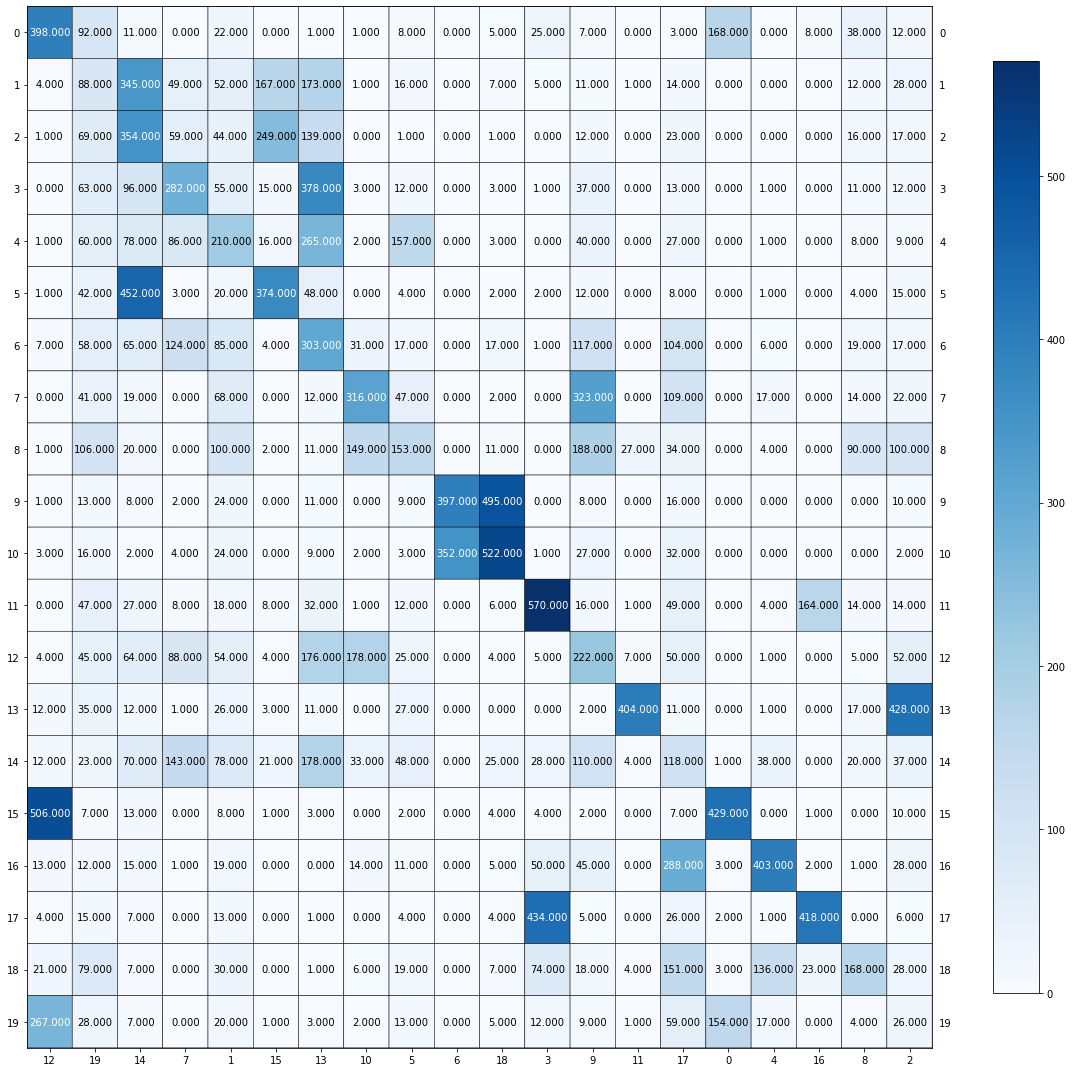

In [66]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## Question 11:

Use UMAP to reduce the dimensionality of the 20 categories TF-IDF
matrix, and apply K-Means clustering with n_components=20 .
Find a good n_components choice for UMAP, and compare the performance of two metrics
by setting metric="euclidean" and metric="cosine" respectively. Report the permuted contingency matrix and the five clustering evaluation metrics
for "euclidean" and "cosine".


Using UMAP to find the best n_components to reduce the data.

Compared the performance with metric = "eucledian" and metric = "cosine"

In [52]:
import umap

Find best n_components with metric = 'eucledian':

In [68]:
#with metric = 'eucledian'
scores = []
for n in n_components:
    umapfit = umap.UMAP(n_components = n, metric = 'euclidean')
    inputs_umap = umapfit.fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_umap)
    get_cluster_metrics(labels, preds)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.313804,0.328794,0.321124,0.205228,0.318863
2,0.468820,0.486809,0.477645,0.369443,0.475912
3,0.489580,0.515532,0.502221,0.392948,0.500556
5,0.499953,0.532349,0.515643,0.392992,0.514013
10,0.497766,0.537320,0.516788,0.396259,0.515141
20,0.502224,0.543511,0.522052,0.402544,0.520413
50,0.508013,0.546018,0.526330,0.409757,0.524718
100,0.514402,0.542460,0.528059,0.419452,0.526467
300,0.515771,0.535938,0.525661,0.417134,0.524086


Using metric ='eucledian', best n_components is 5 (n_components = 300 gives metrics superior only in the third decimal of the fraction)

The evaluation metrics and contingency matrix in this case would be:

In [69]:
inputs_umap = umap.UMAP(n_components = 5, metric = 'euclidean').fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.511601
1,completeness_score,0.531974
2,v_measure_score,0.521589
3,adjusted_rand_score,0.414142
4,adjusted_mutual_info_score,0.520000


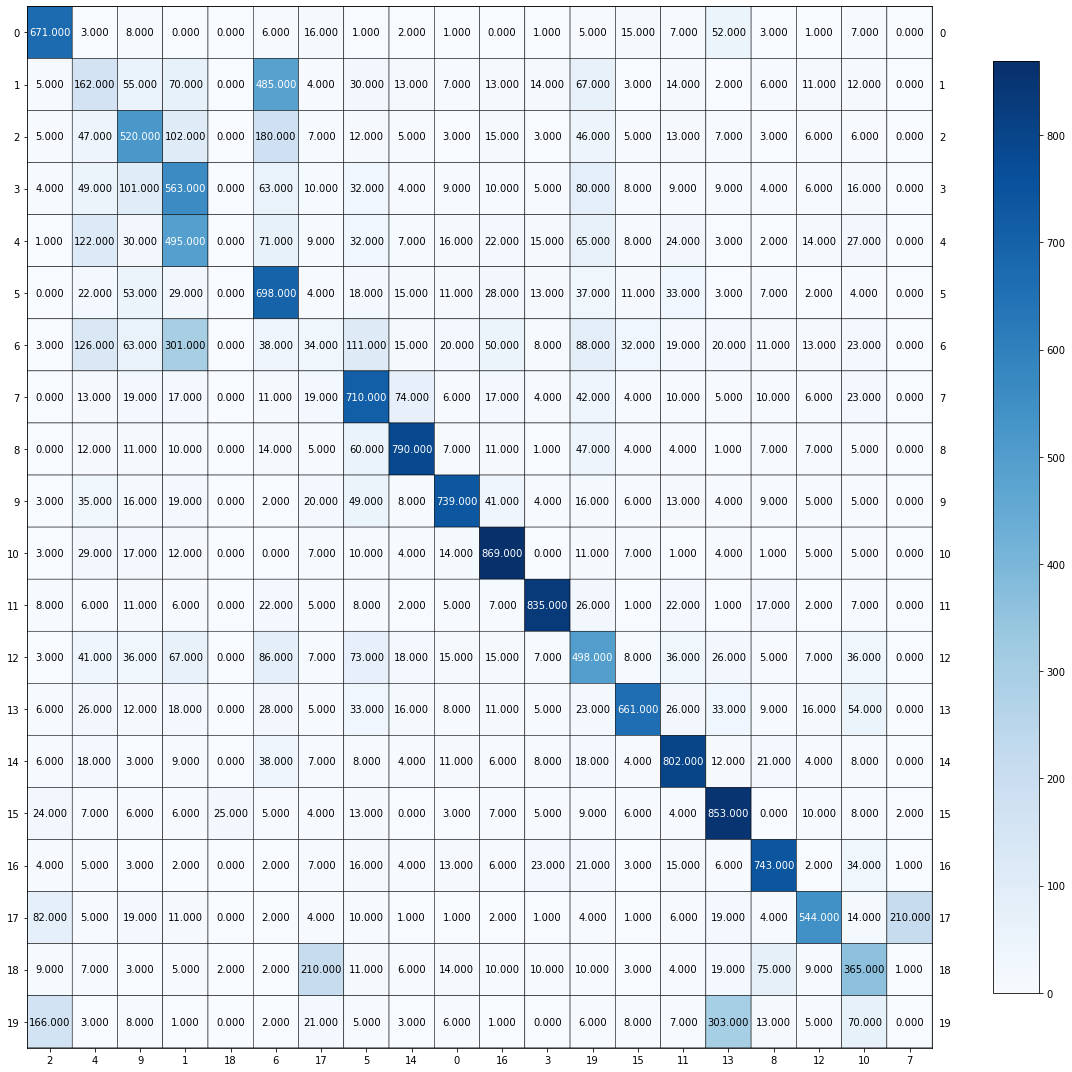

In [70]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

### Question 12: Analyze the contingency matrix.

From the contingency matrices, identify the categories that are prone to be confused with each
other. Does the result make sense?

#### Answer:

Since certain categories are close to each other like religion, atheism, and christianity or IBM and mac hardware, the model must distinguish the other topics well enough. However, it is prone to get confused in clustering categories that are close to each other. This is observed in the above matrix as:

1. Christianity and talks about miscellaneous religions clustered together: The cluster (column) labelled 13 has most of its documents from categories (rows) 15 and 19. This is an encouraging sign because categories 15 and 19 pertain to christianity and talks about miscellaneous religions. The topics being highly similar, were clustered together by the model.

2. IBM PC hardware and Mac hardware clustered together: The cluster (column) labelled 1 has most of its documents from categories (rows) 3 and 4. This is an encouraging sign because categories 3 and 4 pertain to IBM harware and Mac hardware. The topics being highly similar, were clustered together by the model.

3. Atheism and religion clustered together: The cluster (column) labelled 2 has most of its documents from categories (rows) 1 and 19. This is an encouraging sign because categories 1 and 19 pertain to atheism and miscellanous religions. The topics being related, were clustered together by the model.

Similar behaviour although with different labelling is observed on using the 'cosine' metric, as seen below:

Find best n_components with metric = 'cosine':

In [71]:
#with metric = 'cosine'
scores = []
for n in n_components:
    umapfit = umap.UMAP(n_components = n, metric = 'cosine')
    inputs_umap = umapfit.fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_umap)
    get_cluster_metrics(labels, preds)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.326141,0.337057,0.331509,0.220160,0.329310
2,0.475285,0.491008,0.483019,0.375309,0.481307
3,0.485451,0.509786,0.497321,0.393881,0.495632
5,0.501004,0.532950,0.516484,0.399789,0.514858
10,0.502372,0.530903,0.516244,0.407605,0.514623
20,0.510078,0.531100,0.520377,0.414975,0.518783
50,0.500182,0.541944,0.520227,0.394553,0.518588
100,0.498076,0.534279,0.515543,0.387900,0.513894
300,0.497215,0.537664,0.516649,0.394478,0.515015


Using metric = 'cosine', best n_components is: 3 (however, n_components = 5 also give very close metrics)

The evaluation metrics and contingency matrices (using n_components = 3) are:

In [72]:
inputs_umap = umap.UMAP(n_components = 3, metric = 'cosine').fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.491172
1,completeness_score,0.505385
2,v_measure_score,0.498177
3,adjusted_rand_score,0.394992
4,adjusted_mutual_info_score,0.496519


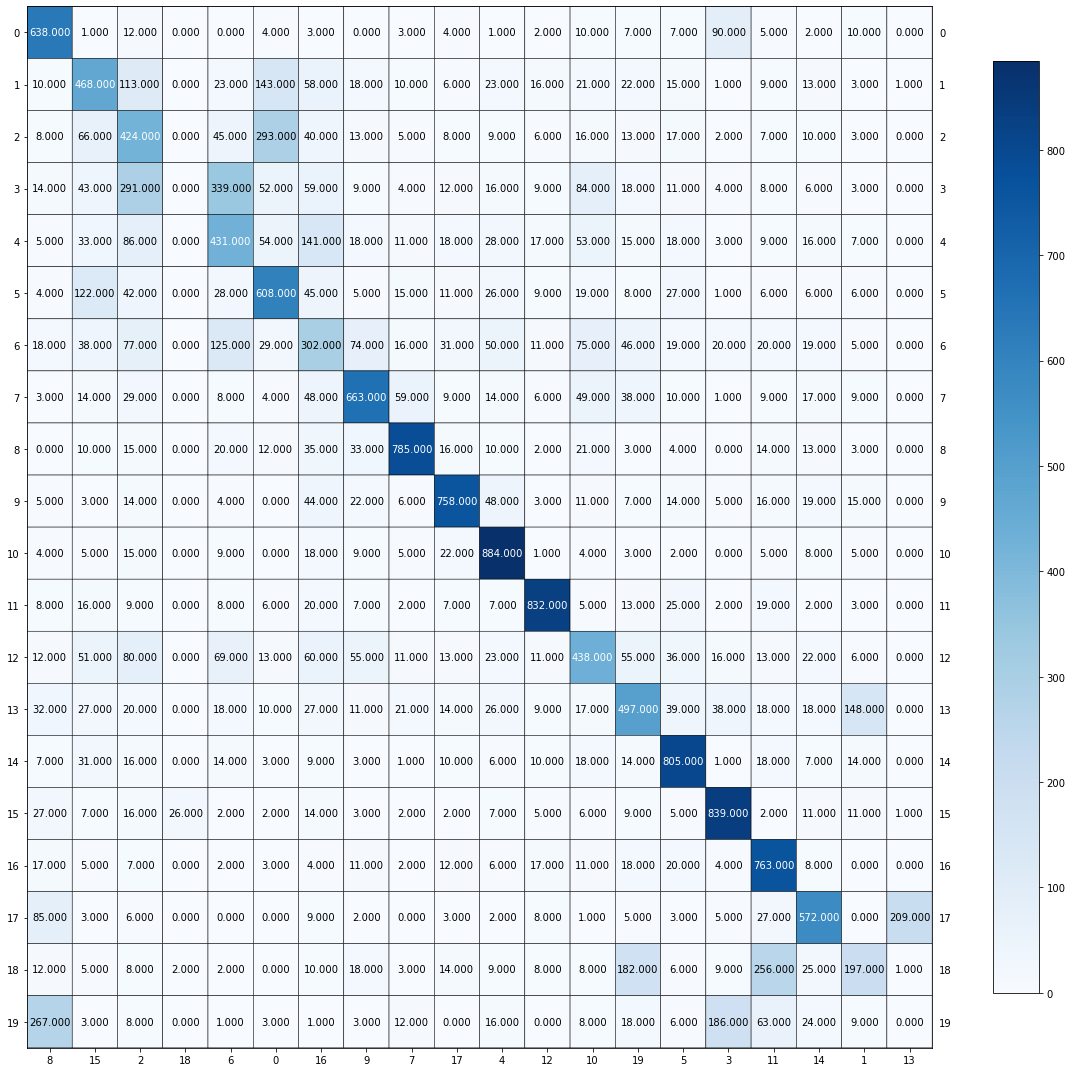

In [73]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

The 'cosine' metric with n_components = 5 gives:

In [27]:
inputs_umap = umap.UMAP(n_components = 5, metric = 'cosine').fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.493709
1,completeness_score,0.522841
2,v_measure_score,0.507858
3,adjusted_rand_score,0.397501
4,adjusted_mutual_info_score,0.506206


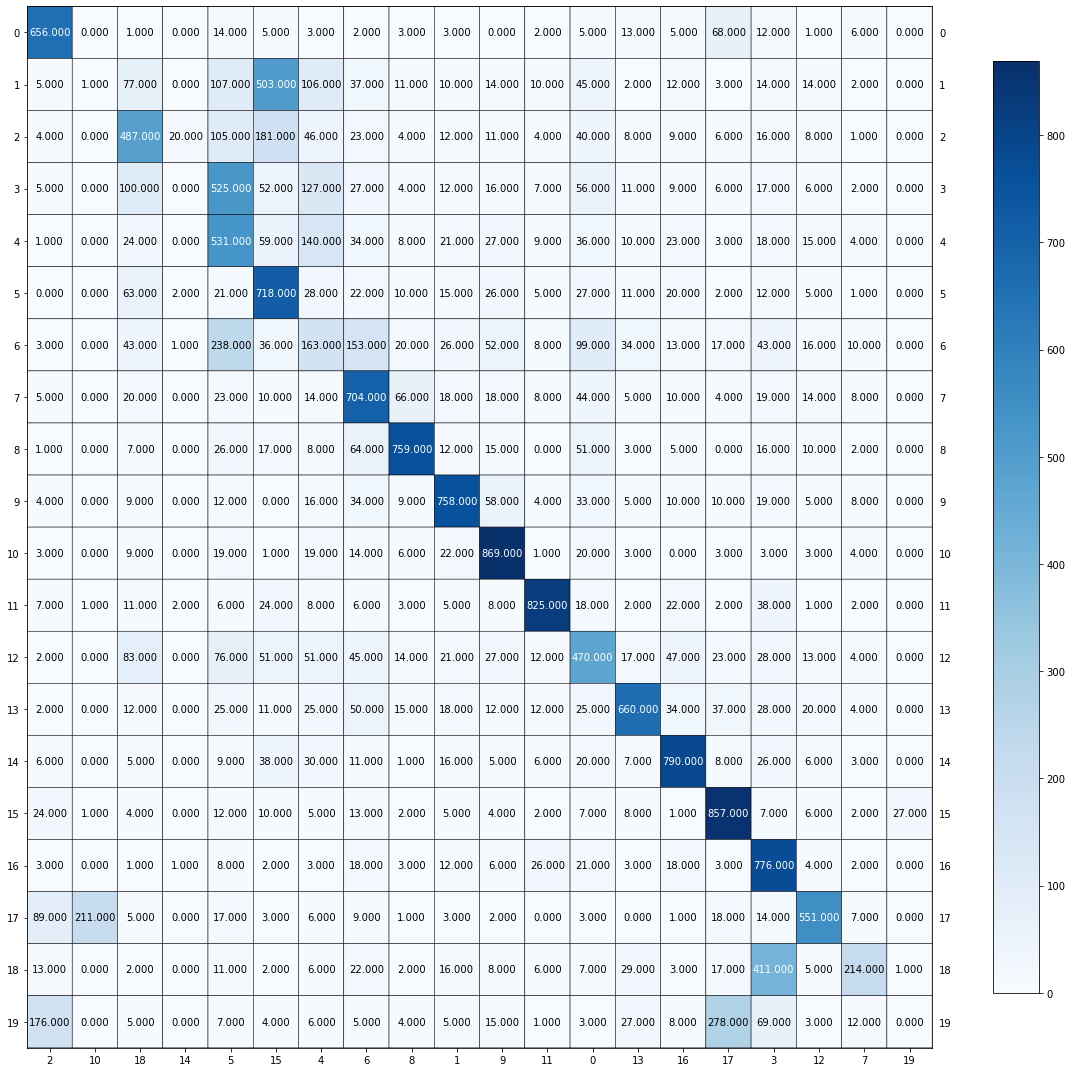

In [75]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## Q 13: Agglomerative clustering

Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single”
linkage criteria.
Report the five clustering evaluation metrics for each case.

A UMAP representation of the inputs is plotted, colored according to the category each document belongs to.

In [8]:
embedding = umap.UMAP().fit_transform(inputs_tfidf)

Text(0.5, 1.0, 'UMAP representation of all documents')

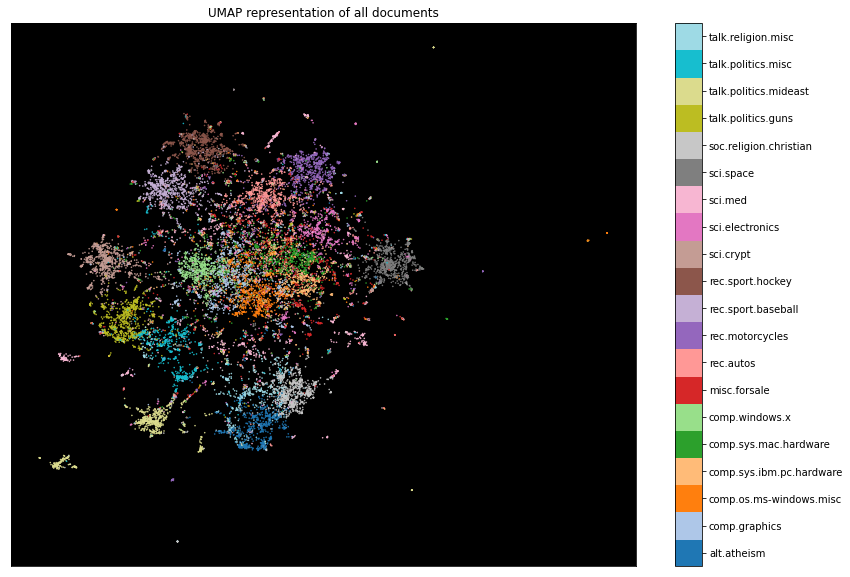

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 10))
ax.set_facecolor('k')
plt.scatter(*embedding.T, s = 0.3, c = labels, cmap = 'tab20', alpha = 1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries = np.arange(21) - 0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(target_names)
plt.title('UMAP representation of all documents')

Comparison between 'ward' and 'single' linkage criteria.

Used UMAP with metric = 'cosine' and n_components = 3, as it gave the best results for k means in the above task

In [53]:
from sklearn.cluster import AgglomerativeClustering

Agglomerative clustering is a bottom-up hierarchial clustering technique where at each step, the pair of clusters that are closest to each other according to some distance metric are merged into one cluster. This process is iterated so that each iteration lowers the total number of clusters by 1. The point at which we stop the clustering is determined by the number of clusters we decide to group the data into.

#### Using 'ward' linkage:

Ward's method aims to minimize the total within-cluster variance. However, it need not give the optimal lowest within-cluster variance since it is contrained by the choices made in forming the previous clusters. 

At any stage, those two clusters shall be merged that lead to the smallest increase in within-cluster varaince after the merger. This can equivalently be described by saying that the two clusters merged have the lowest weighted centroid distance between all pairs of clusters. The metric is given by:

$\frac{n_An_B}{n_A + n_B}\|m_A - m_b\|^2$ where $m_j$ is the centroid of cluster $j$ and $n_j$ is the number of points in it.

The ward method works well for the 'cloud' type of clusters which are dense about a centroid and relatively sparse as we move away from it. Since our UMAP representation of data shows similar behaviour, using the 'ward' criterion serves our clustering well.

In [46]:
inputs_umap = umap.UMAP(n_components = 3, metric = 'cosine').fit_transform(inputs_tfidf)

agglo = AgglomerativeClustering(n_clusters = len(target_names), linkage = 'ward')
preds = agglo.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.495834
1,completeness_score,0.510624
2,v_measure_score,0.503120
3,adjusted_rand_score,0.391852
4,adjusted_mutual_info_score,0.501491


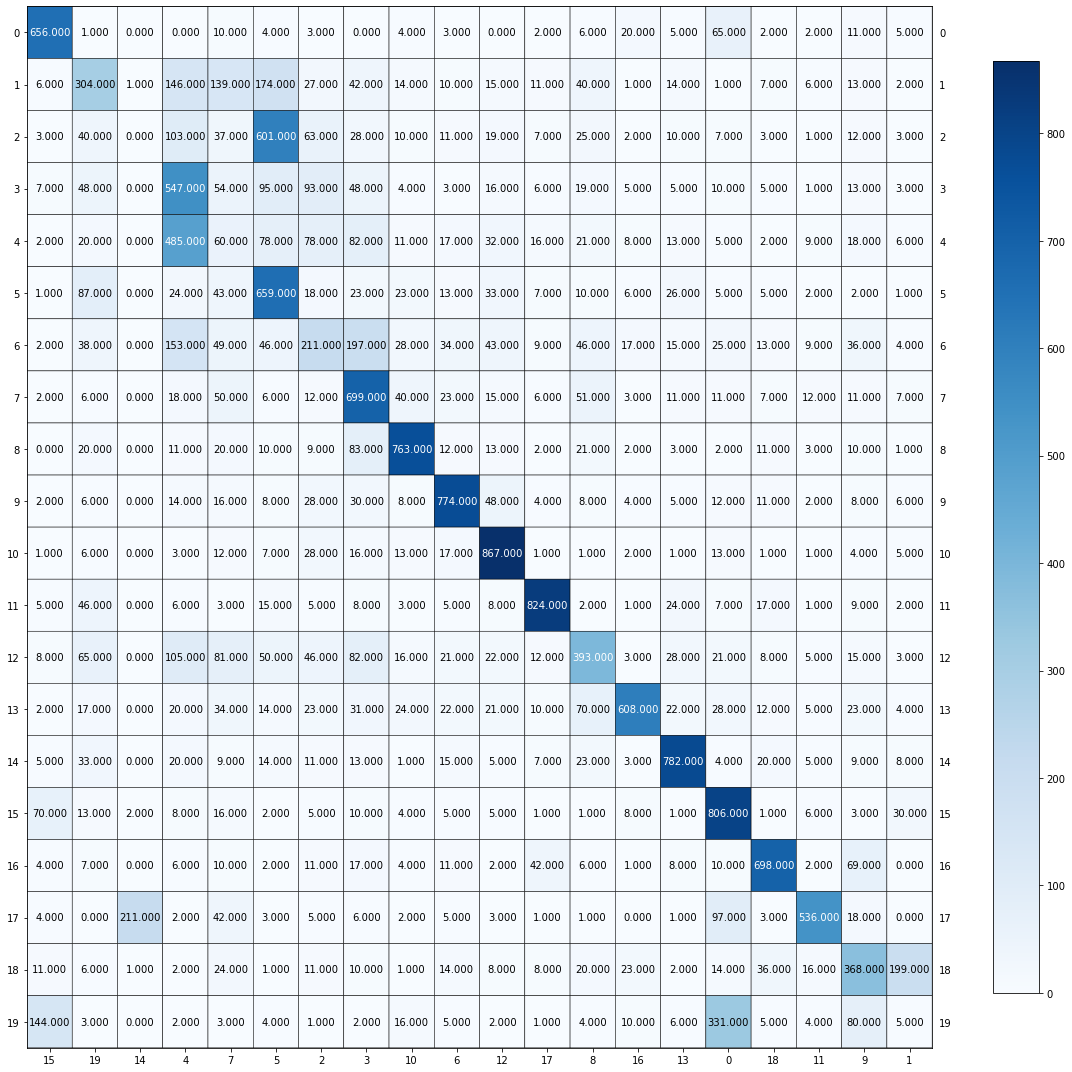

In [47]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

Using 'single' linkage:

The single-linkage clustering criterion determines the distance between two clusters as the smallest distance between any pair of points, one coming from each of the clusters. Thus, the distance between two clusters $A$ and $B$ is given by:

$d_{AB} = min \{ \|a-b\|^2:a \in A, b\in B\}$

At each stage the two closest clusters in this regard are merged. Since all the distances between points in a cluster are not considered in making the merger decision, this clustering generally works only in the case of long 'chain' like clusters.

Since our document clusters do not have this representation (according to the UMAP representation above), single-linkage criterion has very poor behavior in clustering the given dataset.

In [48]:
agglo = AgglomerativeClustering(n_clusters = len(target_names), linkage = 'single')
preds = agglo.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.053183
1,completeness_score,0.435936
2,v_measure_score,0.094801
3,adjusted_rand_score,0.005671
4,adjusted_mutual_info_score,0.089461


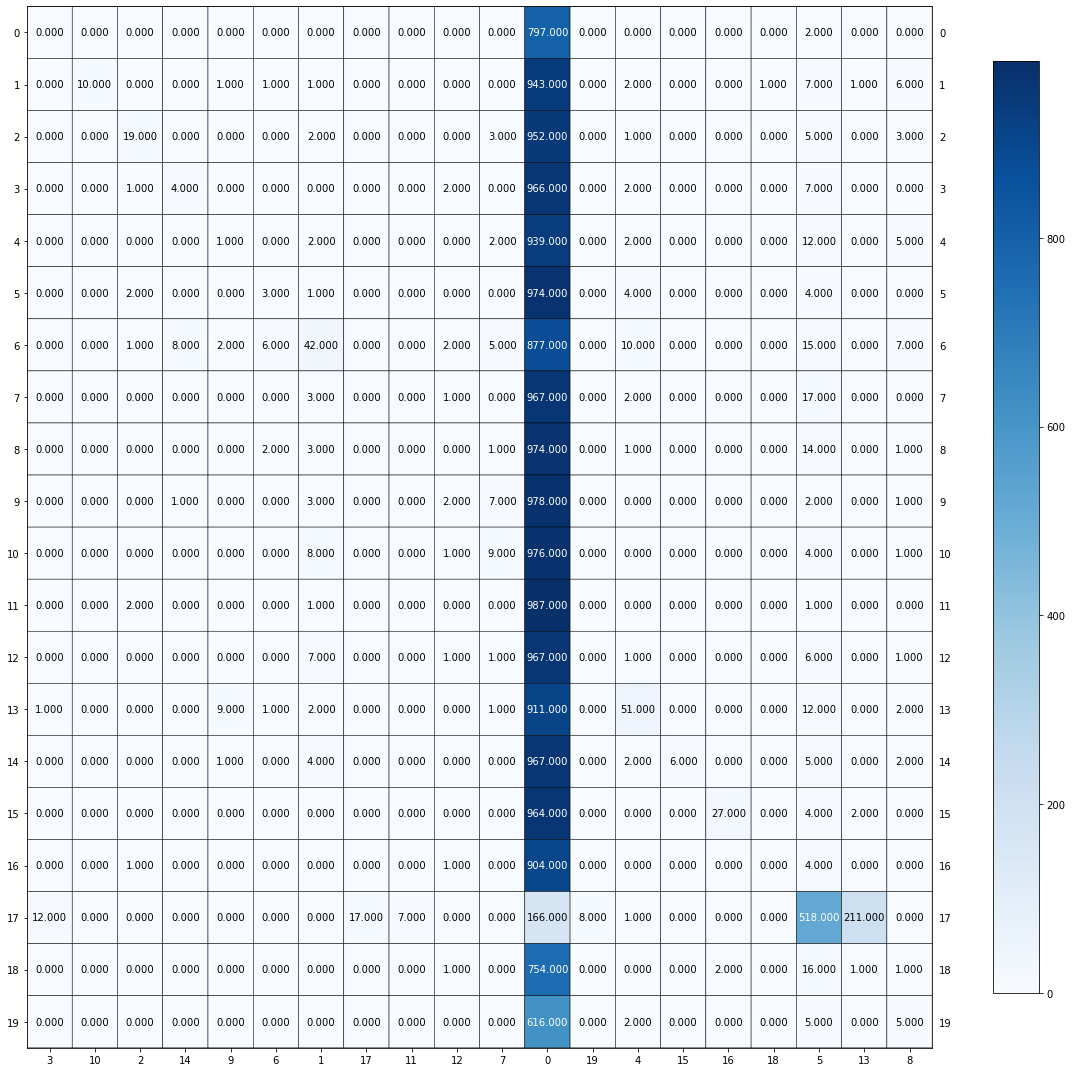

In [49]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## Question 14:

Apply DBSCAN and HDBSCAN on UMAP-transformed 20-category data.
Use min_cluster_size=100 .
Experiment on the hyperparameters and report your findings in terms of the five
clustering evaluation metrics.

## Question 15:

Plot the permuted contingency matrix for the best clustering model from Question 14.
How many clusters are given by the model? What does “-1” mean for the clustering labels?
Interpret the contingency matrix considering the answer to these questions.


#### Answer:

#### DBSCAN and HDBSCAN: 

They are density based clustering approachs. They form clusters based on higly dense areas and hence could take any shape. The advantage of both methods is that in forming clusters from given data points, they also assign some points to be noise. This is a useful feature, especially in large nosiy datasets. The noisy points are those that are in regions of extremely sparse density (ie, there are no neighboring data points close to these noisy points). 
#### The noisy points of the dataset are given the label -1

The basic principle is in identifying core samples (those that have at least a given number of neighbors within a set distance). All core samples that are close to each other than the set distance and their neighbors form a clusters. Points that do not belong to any cluster are labelled as noise (with the label -1).

REF:

Load HDBSCAN: https://pypi.org/project/hdbscan/

Link: https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html?highlight=dbscan#dbscan

Link: https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/#:~:text=Two%20important%20parameters%20are%20required,neighbors%20within%20%E2%80%9Ceps%E2%80%9D%20radius.

Link:https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#:~:text=DBSCAN%20works%20by%20determining%20whether,maximum%20distance%20between%20two%20points.

DBSCAN and HDBSCAN using min_cluster_size = 100

Experimenting on the hyperparameters:

## DBSCAN

Let epsilon vary from 0.05 to 1, in steps of 0.05 and min_samples vary from 5 to 500 in steps of 10

In [88]:
from sklearn.cluster import DBSCAN
inputs_umap = umap.UMAP(n_components = 5, metric = 'cosine').fit_transform(inputs_tfidf)

In [57]:
eps_list = [x * 0.05 for x in range(1, 21)]
min_samples_list = list(range(5,500,10))

scores = []
for ep in eps_list:
    for min_samp in min_samples_list:
        preds = DBSCAN(eps = ep, min_samples = min_samp, n_jobs = -1).fit_predict(inputs_umap)
        row = get_cluster_metrics(labels, preds)['score'].tolist()
        row.append(ep)
        row.append(min_samp)
        scores.append(row)
        #scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
        
titles = get_cluster_metrics(labels, preds)['metric'].tolist()
titles.append("Epsilon")
titles.append("min_samples")
#metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=titles)
metrics_df.to_excel('DBSCAN.xlsx')

For DBSCAN, the best model obtained had eps = 0.55 and min_samples = 115. The top performing models are:

In [37]:

top_DBs = pd.read_excel('DBSCAN.xlsx', header = 0, index_col = 0)
top_DBs.nlargest(5,'adjusted_mutual_info_score')

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score,Epsilon,min_samples
511,0.456490,0.583557,0.512261,0.195460,0.510766,0.55,115
512,0.455876,0.584093,0.512081,0.182874,0.510587,0.55,125
565,0.456140,0.581712,0.511329,0.204580,0.509931,0.60,155
620,0.456960,0.579070,0.510819,0.214268,0.509423,0.65,205
621,0.454159,0.579352,0.509173,0.207271,0.507768,0.65,215


The best DBSCAN model, ran below suggests the number of clusters as: 16

In [69]:
preds = DBSCAN(eps = 0.55, min_samples = 115, n_jobs = -1).fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.457614
1,completeness_score,0.576439
2,v_measure_score,0.510200
3,adjusted_rand_score,0.206263
4,adjusted_mutual_info_score,0.508709


In [70]:
print(np.unique(preds))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [71]:
no_clusters = np.max(preds) + 1
print("Number of clusters as per best DBSCAN is", no_clusters)

Number of clusters as per best DBSCAN is 16


Plotting the permuted matrix:

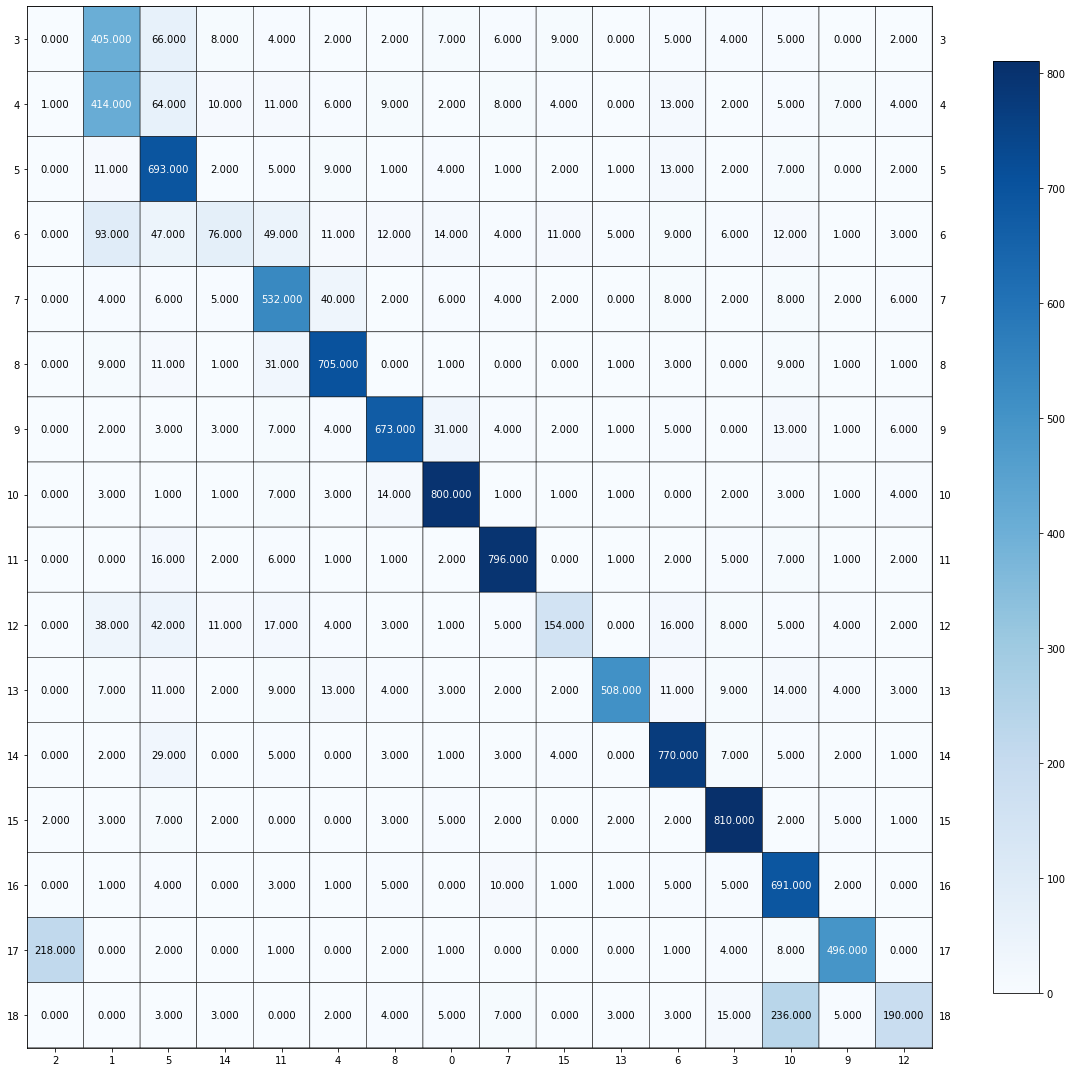

In [72]:
cm = contingency_matrix(labels[preds!=-1], preds[preds!=-1]) #noise labels removed
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

#### Plotting the non-permuted matrix (for better analysis):

Included the noise points too.

In [73]:
cm = contingency_matrix(labels, preds) 

cmap = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(cm)
x=x.style.background_gradient(cmap=cmap)
display(x)                          

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,67,0,0,0,711,3,4,4,1,1,1,4,0,2,1,0,0
1,479,8,60,0,3,4,378,8,9,4,4,6,5,1,0,2,2
2,372,2,92,0,2,2,483,7,3,3,2,2,4,1,0,8,2
3,457,7,405,0,4,2,66,5,6,2,0,5,4,2,0,8,9
4,403,2,414,1,2,6,64,13,8,9,7,5,11,4,0,10,4
5,235,4,11,0,2,9,693,13,1,1,0,7,5,2,1,2,2
6,622,14,93,0,6,11,47,9,4,12,1,12,49,3,5,76,11
7,363,6,4,0,2,40,6,8,4,2,2,8,532,6,0,5,2
8,223,1,9,0,0,705,11,3,0,0,1,9,31,1,1,1,0
9,239,31,2,0,0,4,3,5,4,673,1,13,7,6,1,3,2


Column 0 has points from all ground labels and hence indicates the noisy points.

Cluster (read column) 2 has grouped categories (read rows) 3 and 4. These categories are IBM hardware and Mac hardware and hence the model clustered these very similar labels together.

Another cluster having highly similar topics is cluster (column) 4. It has most of the points from categories (rows) 0, 15, and 19. These categories pertain to atheism, christianity, and miscellaneous religions. The closeness between the topics made it difficult for the model to make three clusters out of them.

Custer 6 has grouped categories 1, 2, and 5 which are graphics, os ms-windows, and windows.x. 


In [66]:
conda install -c conda-forge hdbscan

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sriva\anaconda3

  added / updated specs:
    - hdbscan


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    hdbscan-0.8.26             |   py38h347fdf6_3         506 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         506 KB

The following NEW packages will be INSTALLED:

  hdbscan            conda-forge/win-64::hdbscan-0.8.26-py38h347fdf6_3




hdbscan-0.8.26       | 506 KB    |            |   0% 
hdbscan-0.8.26       | 506 KB    | 3          |   3% 
hdbscan-0.8.26       | 506 KB    | ########## | 100% 
hdbscan-0.8.26       | 506 KB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart 

## HDBSCAN

In [89]:
import hdbscan

In [13]:
clust_eps_list = [x * 0.05 for x in range(1, 21)]
min_samples_list = list(range(5,500,10))

scores = []
for ep in clust_eps_list:
    for min_samp in min_samples_list:
        preds = hdbscan.HDBSCAN(min_cluster_size=100, min_samples = min_samp, cluster_selection_epsilon = ep, core_dist_n_jobs=-1).fit_predict(inputs_umap)
        row = get_cluster_metrics(labels, preds)['score'].tolist()
        row.append(ep)
        row.append(min_samp)
        scores.append(row)
        #scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
        
titles = get_cluster_metrics(labels, preds)['metric'].tolist()
titles.append("Cluster_sel_Epsilon")
titles.append("min_samples")
#metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=titles)
metrics_df.to_excel('HDBSCAN.xlsx')

HDBSCAN suggests the best model to be obtained with min_samples = 215, and cluster_selection_epsilon = 0.05. The top performing models are:

In [80]:

top_HDBs = pd.read_excel('HDBSCAN.xlsx', header = 0, index_col = 0)
top_HDBs.nlargest(5,'adjusted_mutual_info_score')

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score,Cluster_sel_Epsilon,min_samples
21,0.35603,0.572526,0.43904,0.160122,0.437981,0.05,215
71,0.35603,0.572526,0.43904,0.160122,0.437981,0.10,215
121,0.35603,0.572526,0.43904,0.160122,0.437981,0.15,215
171,0.35603,0.572526,0.43904,0.160122,0.437981,0.20,215
221,0.35603,0.572526,0.43904,0.160122,0.437981,0.25,215


The best HDBSCAN, ran below suggests the number of clusters as: 9 (shown below)

In [90]:
preds = hdbscan.HDBSCAN(min_cluster_size=100, min_samples = 215, cluster_selection_epsilon = 0.05, core_dist_n_jobs=-1).fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.354008
1,completeness_score,0.566701
2,v_measure_score,0.435787
3,adjusted_rand_score,0.161766
4,adjusted_mutual_info_score,0.434725


In [91]:
print("The unique labels in case of best HDBSCAN model are:", np.unique(preds))
print("The number of clusters as per the best HDBSCAN model is:", np.max(preds)+1)

The unique labels in case of best HDBSCAN model are: [-1  0  1  2  3  4  5  6  7  8]
The number of clusters as per the best HDBSCAN model is: 9


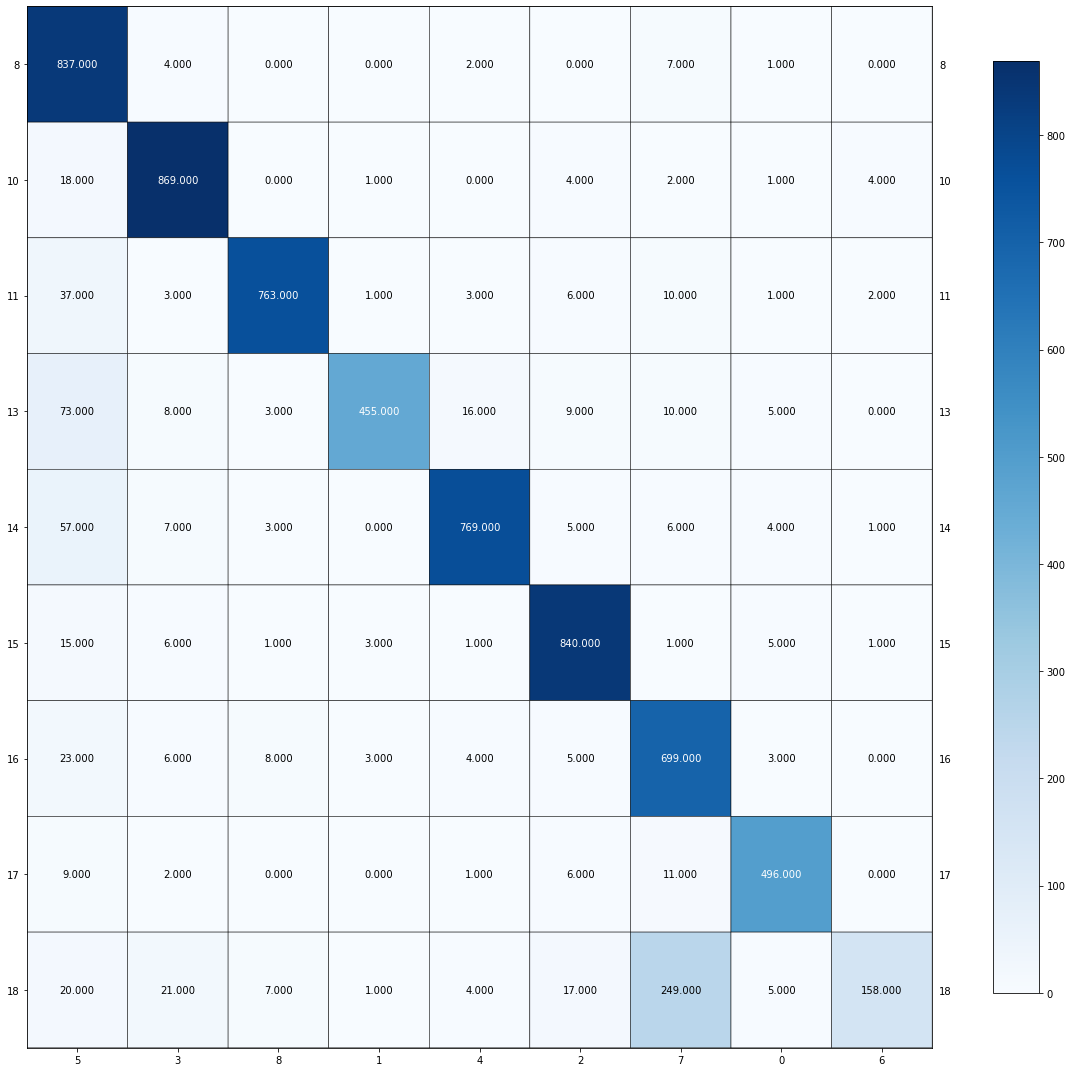

In [92]:
cm = contingency_matrix(labels[preds!=-1], preds[preds!=-1])
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

#### Plotting the non-permuted matrix (for better analysis)

In [93]:
cm = contingency_matrix(labels, preds) 

cmap = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(cm)
x=x.style.background_gradient(cmap=cmap)
display(x)

,0,1,2,3,4,5,6,7,8,9
0,55,1,6,715,1,4,10,2,4,1
1,337,5,1,4,17,3,594,1,4,7
2,200,1,0,1,13,8,754,0,4,4
3,208,0,2,5,10,4,741,2,4,6
4,238,9,6,1,17,13,661,3,6,9
5,184,1,1,2,10,8,778,0,3,1
6,514,2,14,7,29,10,385,2,10,2
7,271,1,0,2,12,4,685,6,7,2
8,145,1,0,0,4,2,837,0,7,0
9,208,2,0,4,716,5,40,5,11,3


The first column indicates noise as it has points from all ground labels. 

Because the model forms only 9 clusters, all ‘computer’ related categories were grouped together (cluster 6).
A surprising find is that category (row) 12 which deals with ‘electronics’ is also included in the same cluster having the computer topics. A major defect in this clustering is the grouping of ‘misc.forsale’, ‘rec.autos’, and ‘rec.motorcycles’ in the same cluster 6.

Other groups are appropriately clustered.

